In [373]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures,OneHotEncoder,LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer


1) LOAD DATASET

In [374]:
# Load the dataset
data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

2) Data Cleaning and Preprocessing

In [375]:
data.replace(" ", np.nan, inplace=True)
data.dropna(inplace=True)
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
data.drop_duplicates(inplace=True)
data.dropna(subset=['TotalCharges'], inplace=True)

In [376]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [377]:
# Manually encode other categorical columns using LabelEncoder
label_encoders = {}
categorical_cols = ['MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'gender', 
'InternetService', 'Contract', 'PaymentMethod','Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']

for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le  # Store label encoder for each column if needed later



In [378]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,0,0,1,0,1,0,1,0,0,...,0,0,0,0,0,1,2,29.85,29.85,0
1,5575-GNVDE,1,0,0,0,34,1,0,0,2,...,2,0,0,0,1,0,3,56.95,1889.50,0
2,3668-QPYBK,1,0,0,0,2,1,0,0,2,...,0,0,0,0,0,1,3,53.85,108.15,1
3,7795-CFOCW,1,0,0,0,45,0,1,0,2,...,2,2,0,0,1,0,0,42.30,1840.75,0
4,9237-HQITU,0,0,0,0,2,1,0,1,0,...,0,0,0,0,0,1,2,70.70,151.65,1


In [379]:
# Scale numerical variables
scaler = StandardScaler()
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

3) Exploratory Data Analysis (EDA):

In [380]:
data.head(), data.describe(include='all')

(   customerID  gender  SeniorCitizen  Partner  Dependents    tenure  \
 0  7590-VHVEG       0              0        1           0 -1.280248   
 1  5575-GNVDE       1              0        0           0  0.064303   
 2  3668-QPYBK       1              0        0           0 -1.239504   
 3  7795-CFOCW       1              0        0           0  0.512486   
 4  9237-HQITU       0              0        0           0 -1.239504   
 
    PhoneService  MultipleLines  InternetService  OnlineSecurity  ...  \
 0             0              1                0               0  ...   
 1             1              0                0               2  ...   
 2             1              0                0               2  ...   
 3             0              1                0               2  ...   
 4             1              0                1               0  ...   
 
    DeviceProtection  TechSupport  StreamingTV  StreamingMovies  Contract  \
 0                 0            0            0   

i. Distribution of Categorical Features

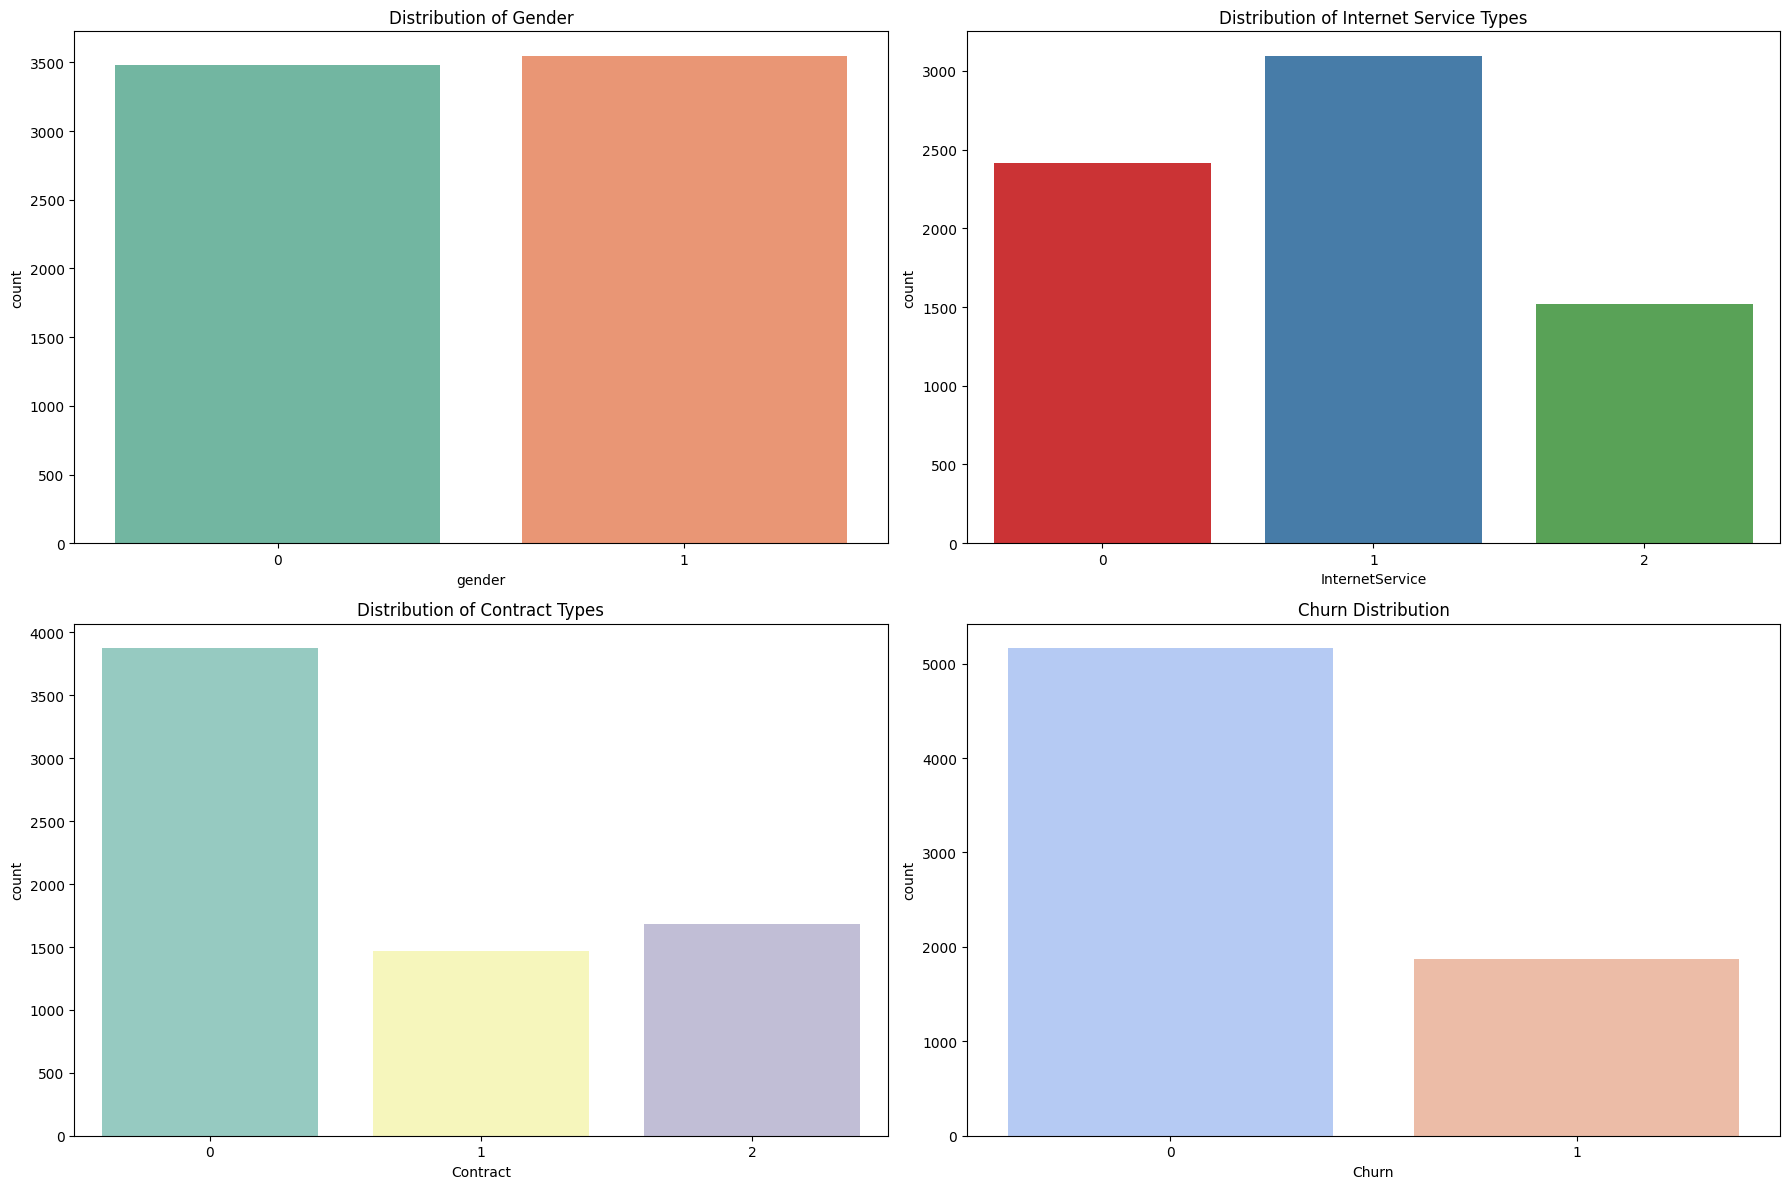

In [381]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the visualization
plt.figure(figsize=(18, 12))

# Plotting distributions of a few categorical columns
plt.subplot(2, 2, 1)
sns.countplot(x='gender', data=data, palette='Set2')
plt.title('Distribution of Gender')

plt.subplot(2, 2, 2)
sns.countplot(x='InternetService', data=data, palette='Set1')
plt.title('Distribution of Internet Service Types')

plt.subplot(2, 2, 3)
sns.countplot(x='Contract', data=data, palette='Set3')
plt.title('Distribution of Contract Types')

plt.subplot(2, 2, 4)
sns.countplot(x='Churn', data=data, palette='coolwarm')
plt.title('Churn Distribution')

plt.tight_layout()
plt.show()

*Gender Distribution:
The distribution between genders is nearly balanced, suggesting no significant bias towards any gender in the dataset.

*Internet Service Types:
Most customers use DSL or Fiber optic services, with Fiber optic being slightly more prevalent than DSL. A smaller segment does not use internet services.

*Contract Types:
The majority of customers are on a month-to-month contract, indicating a potential high turnover rate. One-year and two-year contracts have fewer subscribers, suggesting longer-term contracts are less popular.

*Churn Distribution:
There's a significant difference between the number of customers who churn and those who do not, with a larger proportion of customers staying with the company.

ii. Distributions of numerical features

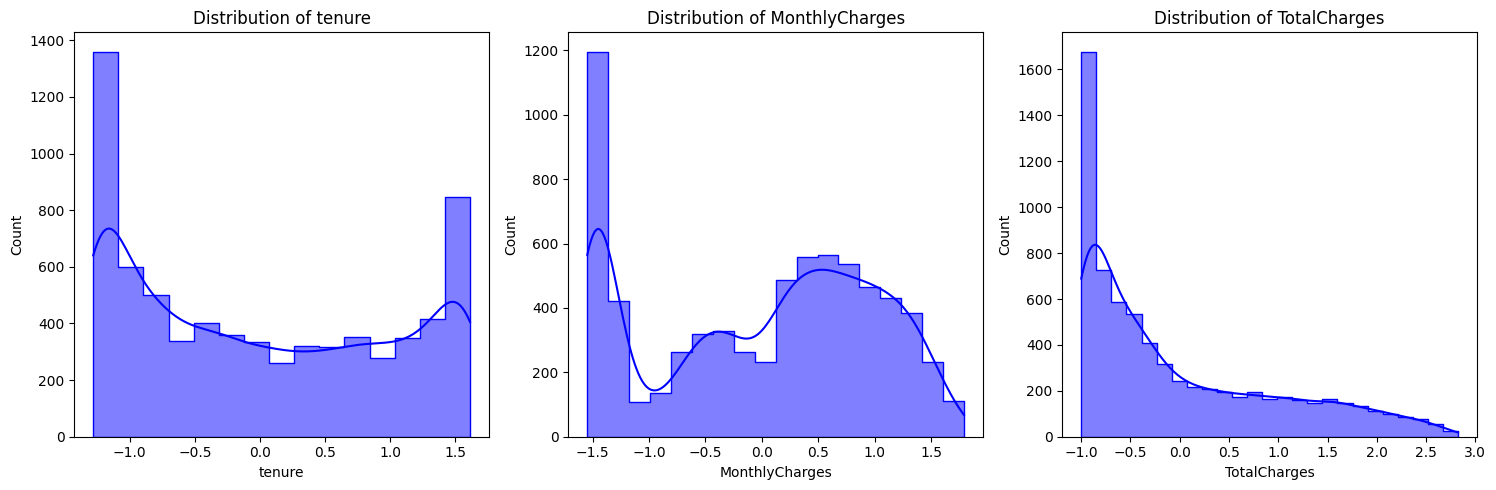

In [382]:
# Plotting distributions of numerical features
plt.figure(figsize=(15, 5))

# Plot histograms for each numerical column
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(1, 3, i)
    sns.histplot(data[col], kde=True, element='step', color='blue')
    plt.title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

Tenure:
The distribution shows a bi-modal pattern, with a large number of customers having either very short or very long tenure. This suggests two distinct groups: new customers and long-term loyal customers.

Monthly Charges:
The distribution is somewhat right-skewed, indicating that a significant number of customers pay lower monthly charges, with fewer customers at the higher end of the charge spectrum.

Total Charges:
This shows a right-skewed distribution as well, which makes sense as customers who have been with the company longer (and possibly paying more monthly) accumulate higher total charges over time.

iii.Effect on churn

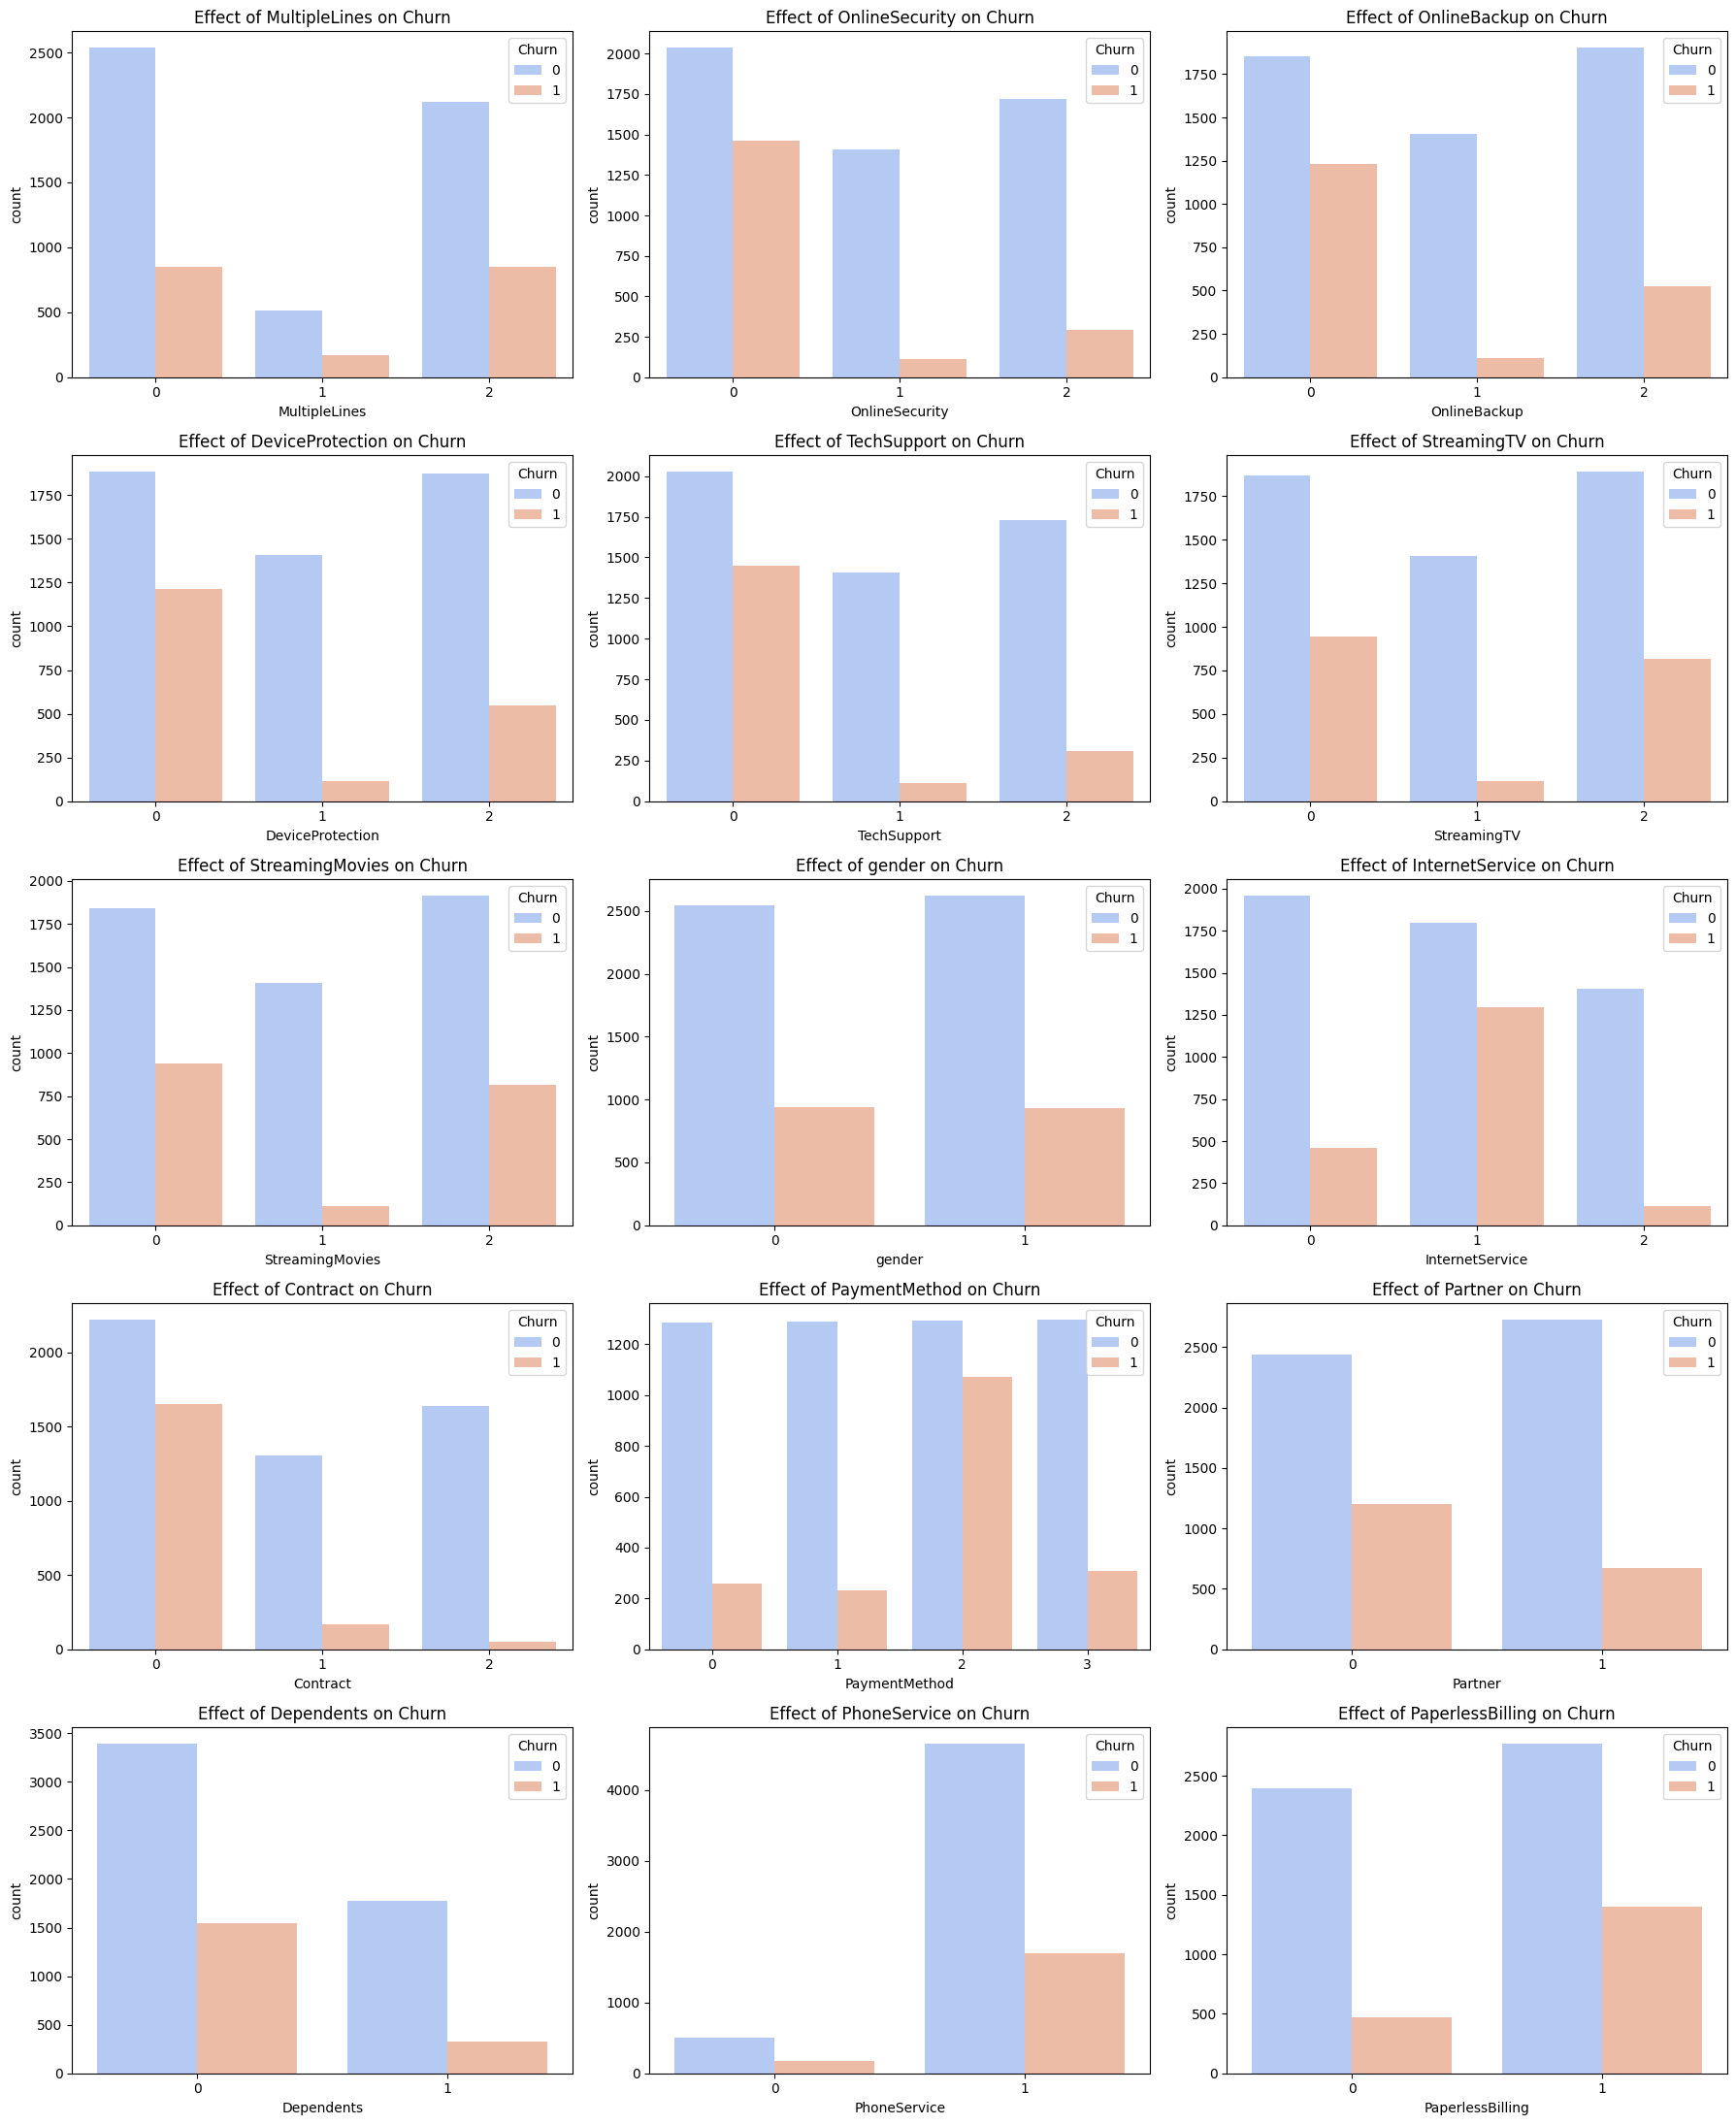

In [383]:
# Setting up a grid of plots for the categorical variables and their effect on Churn
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(18, 22))
axes = axes.flatten()  # Flatten the array of axes for easier iteration

# Plotting the effect of each categorical feature on Churn
for i, col in enumerate(categorical_cols[:-1]):  # Excluding 'Churn' itself from the list
    sns.countplot(data=data, x=col, hue='Churn', palette='coolwarm', ax=axes[i])
    axes[i].set_title(f'Effect of {col} on Churn')
    axes[i].legend(title='Churn')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

Each plot shows the count of customers who stayed versus those who left (churned) across different categories of each variable.
Features like InternetService, OnlineSecurity, TechSupport, and Contract show distinct patterns indicating varying levels of impact on churn.

For instance:
Internet Service: Customers with fiber optic service tend to churn more compared to those with DSL or no internet service.
Online Security and Tech Support: Customers without these services are more likely to churn.
Contract Length: Month-to-month customers have a much higher churn rate compared to those with longer contracts.

iv. Correlation Matrix

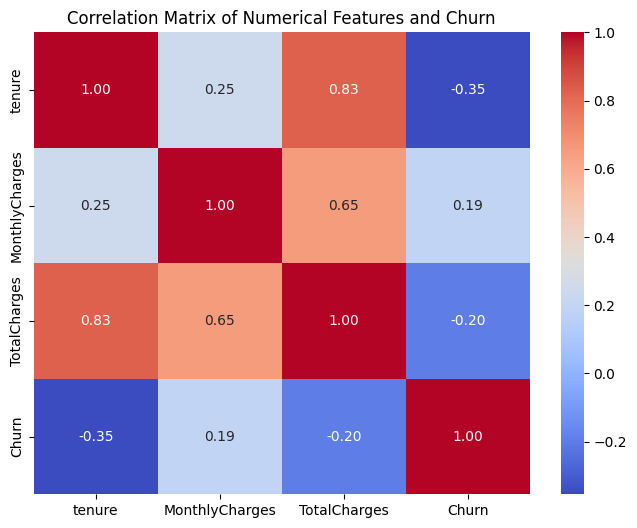

In [384]:
# Compute the correlation matrix
correlation_matrix = data[numerical_cols + ['Churn']].corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix of Numerical Features and Churn')
plt.show()


4. Feature Engineering:

In [385]:
# Enhanced Feature Engineering
data['TotalCharges_cubed'] = data['TotalCharges'] ** 3
data['Interact_MonthlyContract'] = data['Contract'] * data['MonthlyCharges']
data['HighChurn_PaymentMethod'] = (data['PaymentMethod'] == label_encoders['PaymentMethod'].transform(['Electronic check'])[0]).astype(int)
data['Senior_and_Alone'] = data['SeniorCitizen'] * (1 - data['Dependents'])

data['MonthlyTotalRatio'] = data['MonthlyCharges'] / (data['TotalCharges'] + 1e-5)
service_categories = ['PhoneService', 'InternetService', 'StreamingTV', 'StreamingMovies']
data['BundlePenetration'] = data[service_categories].gt(0).sum(axis=1)



5. Building the Churn Prediction Model:

In [386]:
# Define features and target variable
X = data.drop(['Churn', 'customerID'], axis=1) 
y = data['Churn']

In [387]:
# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

In [388]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)


i.Comparing different models

In [389]:
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100)
}

# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    auc = roc_auc_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    
    results[name] = {
        'AUC': auc,
        'F1 Score': f1,
        'Recall': recall,
        'Precision': precision
    }

# Display results
for model_name, metrics in results.items():
    print(f"Model: {model_name}")
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name}: {metric_value:.4f}")
    print("\n")

Model: Logistic Regression
AUC: 0.7964
F1 Score: 0.8059
Recall: 0.8494
Precision: 0.7667


Model: Random Forest
AUC: 0.8408
F1 Score: 0.8430
Recall: 0.8581
Precision: 0.8283


Model: Gradient Boosting
AUC: 0.8085
F1 Score: 0.8163
Recall: 0.8552
Precision: 0.7808




ii.Hyper Tuning using grid search

In [390]:
# Define the parameter grid
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [100, 300, 500]
}

# Initialize the RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=3, n_jobs=1, verbose=2, scoring='roc_auc')
grid_search.fit(X_train, y_train)

# Best parameters and best model from grid search
best_params = grid_search.best_params_
best_rf = grid_search.best_estimator_

print("Best parameters found: ", best_params)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   5.6s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   4.3s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   4.6s
Best parameters found:  {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


6. Model Evaluation:

In [391]:
y_pred_rf = best_rf.predict(X_test)

# Output classification report and AUC score
print("RandomForest Classifier:")
print(classification_report(y_test, y_pred_rf))
print("AUC Score:", roc_auc_score(y_test, y_pred_rf))


RandomForest Classifier:
              precision    recall  f1-score   support

           0       0.86      0.83      0.85      1037
           1       0.84      0.86      0.85      1029

    accuracy                           0.85      2066
   macro avg       0.85      0.85      0.85      2066
weighted avg       0.85      0.85      0.85      2066

AUC Score: 0.8471051183939619
